In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import torch
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from tensorflow.keras.models import Model



In [37]:
#Q3

def softmax(x, axis=-1):

    x = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)


def attention(Q, K, V):

    d_k = Q.shape[1]

    scores = np.dot(Q, K.T)

    scores = scores / np.sqrt(d_k)

    weights = softmax(scores)

    output = np.dot(weights, V)

    return output, weights


In [38]:
#Q4
def masked_attention(Q, K, V):

    d_k = Q.shape[1]

    seq_len = Q.shape[0]


    scores = np.dot(Q, K.T)
    scores = scores / np.sqrt(d_k)


    mask = np.triu(np.ones((seq_len, seq_len)), k=1)

    scores[mask == 1] = -np.inf


    weights = softmax(scores)


    output = np.dot(weights, V)

    return output, weights


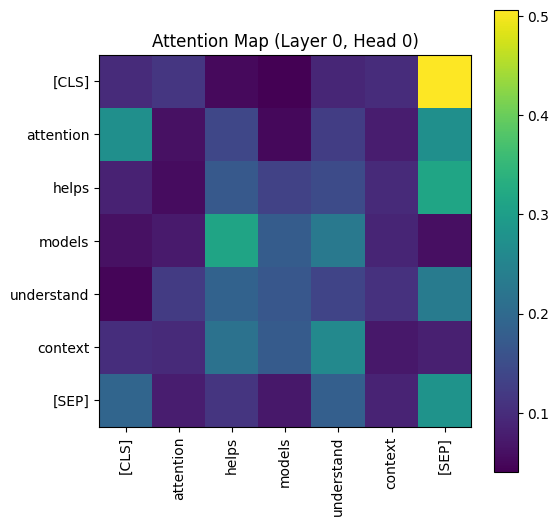

In [39]:
#Q5
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained(
    "bert-base-uncased",
    output_attentions=True
)

model.eval()
sentence = "attention helps models understand context"

inputs = tokenizer(sentence, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions
layer = 0
head = 0

attn_matrix = attentions[layer][0][head].numpy()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

plt.figure(figsize=(6, 6))
plt.imshow(attn_matrix)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.colorbar()
plt.title("Attention Map (Layer 0, Head 0)")
plt.show()



In [40]:
class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(max_len, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1.0 / tf.pow(
            10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32)
        )
        return pos * angle_rates

    def positional_encoding(self, max_len, d_model):
        angle_rads = self.get_angles(
            pos=tf.cast(tf.range(max_len)[:, tf.newaxis], tf.float32),
            i=tf.cast(tf.range(d_model)[tf.newaxis, :], tf.float32),
            d_model=d_model
        )

        angle_rads = tf.where(
            tf.range(d_model) % 2 == 0,
            tf.sin(angle_rads),
            tf.cos(angle_rads)
        )

        return angle_rads[tf.newaxis, ...]

    def call(self, x):
        return x + tf.cast(self.pos_encoding[:, :tf.shape(x)[1], :], x.dtype)


In [41]:
def transformer_encoder_block(embed_dim, num_heads, ff_dim):
    inputs = layers.Input(shape=(None, embed_dim))

    x = layers.LayerNormalization()(inputs)

    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads
    )(x, x)

    x = layers.Add()([inputs, attention_output])

    ff = layers.LayerNormalization()(x)
    ff = layers.Dense(ff_dim, activation="relu")(ff)
    ff = layers.Dense(embed_dim)(ff)

    x = layers.Add()([x, ff])

    return Model(inputs, x)


In [42]:
def build_transformer(
    max_len=100,
    vocab_size=10000,
    embed_dim=64,
    num_heads=4,
    ff_dim=128,
    num_layers=3
):
    inputs = layers.Input(shape=(None,), dtype=tf.int32)

    x = layers.Embedding(vocab_size, embed_dim)(inputs)
    x = PositionalEncoding(max_len, embed_dim)(x)

    for _ in range(num_layers):
        x = transformer_encoder_block(embed_dim, num_heads, ff_dim)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return Model(inputs, outputs)

In [43]:
model = build_transformer()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, None, 64)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_9           │ (None, None, 64)       │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_4 (Functional)       │ (None, None, 64)       │        33,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_5 (Functional)       │ (None, None, 64)       │        33,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_6 (Functional)       │ (None, None, 64)       │        33,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 744,641 (2.84 MB)

 Trainable params: 744,641 (2.84 MB)

 Non-trainable params: 0 (0.00 B)